This dataset contains the result of an A/B test where two groups, the control group and the treatment group, were exposed to an old webpage and a new webpage respectively. The purpose of this test was to determine if the new webpage resulted in a significant increase in conversions compared to the old webpage. Each row represents a unique user and shows whether they’re in the control or treatment group and whether they converted or not.

In [90]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('C:\\ForProject\\ab_data.csv', sep = ';')

Let's check our data on nulls, dupicates and other 

In [4]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [5]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

So, we can see that some people in control group saw a new page, also some people in treatment group saw an old page. Probably some bags. Let's change this!

In [7]:
df_new = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | 
                    (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')]

In [85]:
df_new

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [8]:
df_new.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Now check on duplicates

In [9]:
df_new['user_id'].duplicated().sum()

1

In [11]:
df_new[df_new.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
df_new = df_new.drop_duplicates(subset='user_id', keep="first")

Once my data was cleaned, I wanted to get a better understanding of my data. I plotted the data against a bar chart to see what the proportion of conversions was for both groups. 

(0.0, 0.17)

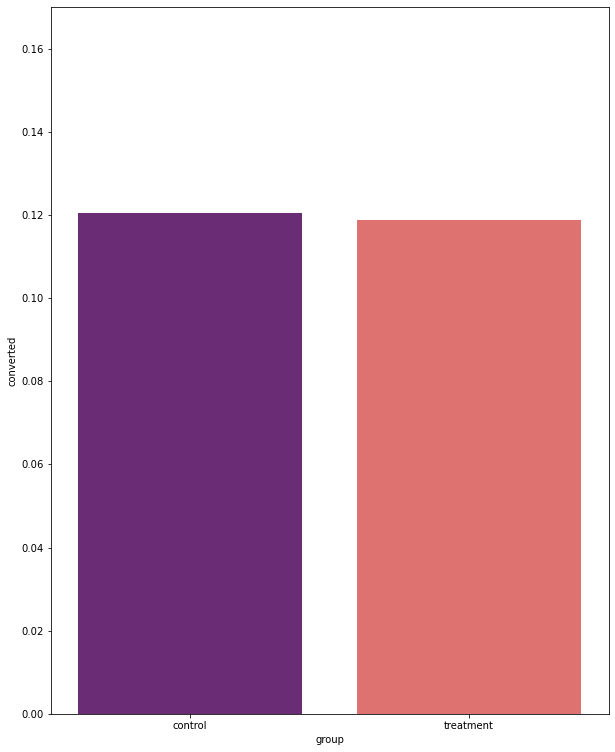

In [68]:
plt.figure(figsize=(10,13))

sns.barplot(x='group', y='converted', data=df_new, ci=False, palette='magma')
plt.ylim(0, 0.17)

Convertion rate is a little bit lower in treatment situation, but we need to check if this difference statistically significant. :)

<AxesSubplot:xlabel='group,landing_page,converted'>

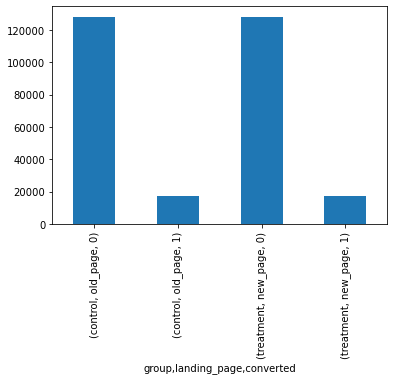

In [14]:
groups = df_new.groupby(['group','landing_page','converted']).size()
groups.plot.bar()

In internet i found some figure that shows how to use different statistical methods to make A/B testing successful based on the metrics, sample size, and sampling distributions of your data. So, i prefer to use Pearson Chi Square Test (because sample size of the data is large) or Z-test. First would be Chi Square Test

H0: conversion rate of Control verson = conversion rate of treatmentment

H1: conversion rate of Control verson != conversion rate of treatmentment

In [88]:
df_counts = pd.DataFrame({"Control_Count": df_new[df_new.group=="control"].converted.value_counts(),
              "Treatment_Count": df_new[df_new.group=="treatment"].converted.value_counts()}).to_numpy()

In [89]:
df_counts

array([[127785, 128046],
       [ 17489,  17264]], dtype=int64)

In [81]:
p = scipy.stats.chi2_contingency(df_counts,correction=False)[1]
print(f'P-value : {p}')

P-value : 0.18988337448194853


Based on the p-value of 0.1899 which is much higher then 0.05, we can not reject the null hypothesis.

Our new page design have same similar effect with the old one 

But still, i will do a Z-test. Do some transformations for this.

In [97]:
Control_Results = df_new[df_new['group'] == 'control'].converted
Treatment_Results = df_new[df_new['group'] == 'treatment'].converted
n_con = Control_Results.count()
n_treat = Treatment_Results.count()
successes = [Control_Results.sum(), Treatment_Results.sum()]
nobs = [n_con, n_treat]

In [101]:
z_stat, p_val = proportions_ztest(successes, nobs=nobs)
print(f'Statistics = {z_stat} \n P-value = {p_val}')

Statistics = 1.3109241984234394 
 P-value = 0.18988337448195103


Actually, we have the same numbers. The p-value was calculated to be 19%. Assuming a 5% level of significance, we can deduce that there is no significance in conversions between the old and new webpage.